Environment Setup

In [1]:
import franka_env
import numpy as np
import gymnasium as gym
import matplotlib.pyplot as plt
from stable_baselines3 import SAC,DDPG,PPO
from sb3_contrib.tqc import TQC
from franka_env import load_success_rate

Push Test(Conventional Method)

In [2]:
env = gym.make("FrankaPushSparse", render_mode="human")
num_episodes = 10
successful_episodes = 0
total_steps = 0
frames = []

# Move the end-effector to the target position
def move_to_position(env, object_position, target_position, z_offset=0.08, descent_steps=5, descent_speed=10, push_steps=45, push_speed=5):
        # Parameters:
        # z_offset: Height offset above the object to avoid collisions
        # descent_steps: Number of steps to gradually descend to the object
        # descent_speed: Speed factor for descending movements
        # push_steps: Number of steps for pushing the object
        # push_speed: Speed factor for pushing movements

    global total_steps
    success = False

    # Compute approach position based on the object's and target's positions
    def compute_approach_position(object_position, target_position):
        direction_vector = target_position - object_position
        direction_vector = direction_vector / np.linalg.norm(direction_vector[:2])
        approach_position = object_position - direction_vector * 0.05
        approach_position[2] = 0
        return approach_position

    # Initial approach above the target to avoid collision with the object
    approach_position = compute_approach_position(object_position, target_position)
    target_position_above = np.array([approach_position[0], approach_position[1], approach_position[2] + z_offset])

    # Compute the action to push the object towards the target
    for step in range(descent_steps):
        current_position = env.unwrapped.get_ee_position()[:3]
        intermediate_position = target_position_above - (target_position_above - approach_position) * (step / descent_steps)
        action = np.clip((intermediate_position - current_position) * descent_speed, -1, 1)
        env.step(action)
        env.render()
        frames.append(env.render())
        total_steps += 1

    action_dim = env.action_space.shape[0]

    for step in range(push_steps):
        current_position = env.unwrapped.get_ee_position()[:3]
        observation = env.unwrapped._get_obs()
        object_position = observation["achieved_goal"]

        if env.unwrapped._is_success(object_position, target_position):
            success = True
            break

        # Check if end-effector has separated from the object
        distance_to_object = np.linalg.norm(current_position[:3] - object_position[:3])

        # If separated, re-approach the object
        if distance_to_object > 0.1:
            approach_position = compute_approach_position(object_position, target_position)
            target_position_above = np.array([approach_position[0], approach_position[1], approach_position[2] + z_offset])

            for descent_step in range(descent_steps):
                current_position = env.unwrapped.get_ee_position()[:3]
                intermediate_position = target_position_above - (target_position_above - approach_position) * (descent_step / descent_steps)
                action = np.clip((intermediate_position - current_position) * descent_speed, -1, 1)
                env.step(action)
                env.render()
                frames.append(env.render())
                total_steps += 1

        action = np.clip((target_position[:2] - object_position[:2]) * push_speed, -1, 1)
        action = np.append(action, 0)
        observation, reward, done, truncated, info = env.step(action)
        env.render()
        frames.append(env.render())
        total_steps += 1

    env.reset()
    return success

for i in range(num_episodes):
    observation, info = env.reset()
    object_position = observation["achieved_goal"]
    target_position = observation["desired_goal"]
    if move_to_position(env, object_position, target_position):
        successful_episodes += 1

env.close()

print(f"Total time steps taken: {total_steps}")

success_rate = successful_episodes / num_episodes * 100
print(f"Success rate: {success_rate:.2f}%")

Total time steps taken: 144
Success rate: 100.00%


Push Test(PPO)

In [3]:
env = gym.make("FrankaPushSparse", render_mode="human")
model = PPO.load('model/PPO_push0.zip', env=env)
num_episodes = 10
successful_episodes = 0
total_steps = 0
frames = []

for i in range(num_episodes):
    obs, info = env.reset()
    done, truncated = False, False
    while not (done or truncated):
        action, _states = model.predict(obs, deterministic=True)
        obs, reward, done, truncated, info = env.step(action)
        env.render()
        frames.append(env.render())
        total_steps += 1
        if done:
                successful_episodes += 1
env.close()

print(f"Total time steps taken: {total_steps}")

success_rate = successful_episodes / num_episodes * 100
print(f"Success rate: {success_rate:.2f}%")

Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Total time steps taken: 277
Success rate: 50.00%


Push Test(SAC)

In [4]:
env = gym.make("FrankaPushSparse", render_mode="human")
model = SAC.load('model/SAC_push0.zip', env=env)
num_episodes = 10
successful_episodes = 0
total_steps = 0
frames = []

for i in range(num_episodes):
    obs, info = env.reset()
    done, truncated = False, False
    while not (done or truncated):
        action, _states = model.predict(obs, deterministic=True)
        obs, reward, done, truncated, info = env.step(action)
        env.render()
        frames.append(env.render())
        total_steps += 1
        if done:
                successful_episodes += 1
env.close()

print(f"Total time steps taken: {total_steps}")

success_rate = successful_episodes / num_episodes * 100
print(f"Success rate: {success_rate:.2f}%")

Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Total time steps taken: 63
Success rate: 100.00%


Push Test(DDPG)

In [5]:
env = gym.make("FrankaPushSparse", render_mode="human")
model = DDPG.load('model/DDPG_push0.zip', env=env)
num_episodes = 10
successful_episodes = 0
total_steps = 0

for i in range(num_episodes):
    obs, info = env.reset()
    done, truncated = False, False
    while not (done or truncated):
        action, _states = model.predict(obs, deterministic=True)
        obs, reward, done, truncated, info = env.step(action)
        env.render()
        total_steps += 1
        if done:
                successful_episodes += 1
env.close()

print(f"Total time steps taken: {total_steps}")

success_rate = successful_episodes / num_episodes * 100
print(f"Success rate: {success_rate:.2f}%")

Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Total time steps taken: 72
Success rate: 100.00%


Push Test(TQC)

In [6]:
env = gym.make("FrankaPushSparse", render_mode="human")
model = TQC.load('model/TQC_push0.zip', env=env)
num_episodes = 10
successful_episodes = 0
total_steps = 0

for i in range(num_episodes):
    obs, info = env.reset()
    done, truncated = False, False
    while not (done or truncated):
        action, _states = model.predict(obs, deterministic=True)
        obs, reward, done, truncated, info = env.step(action)
        env.render()
        total_steps += 1
        if done:
                successful_episodes += 1
env.close()

print(f"Total time steps taken: {total_steps}")

success_rate = successful_episodes / num_episodes * 100
print(f"Success rate: {success_rate:.2f}%")

Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Total time steps taken: 66
Success rate: 100.00%


Push Evaluate

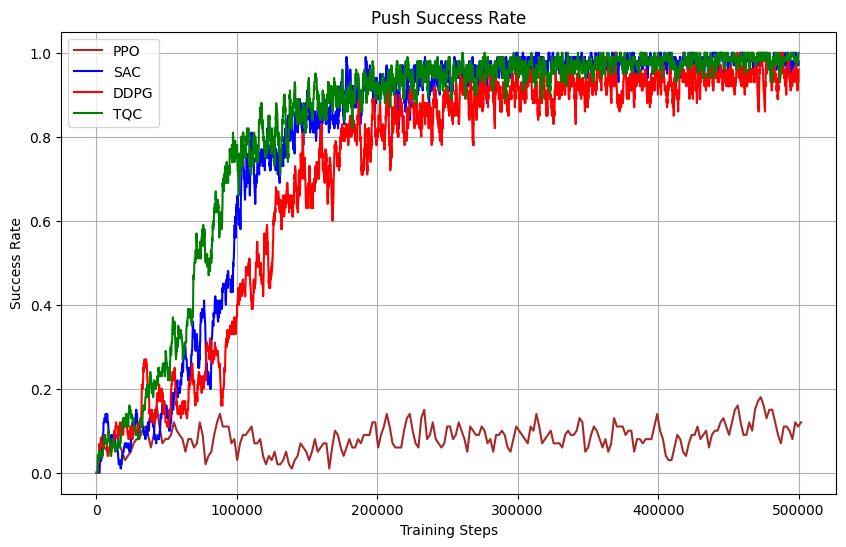

In [7]:
log_dir_1 = './tensorboard/ppo_push/PPO_0/'
log_dir_2 = './tensorboard/sac_push/SAC_0/'
log_dir_3 = './tensorboard/ddpg_push/DDPG_0/'
log_dir_4 = './tensorboard/tqc_push/TQC_0/'

df1 = load_success_rate(log_dir_1)
df2 = load_success_rate(log_dir_2)
df3 = load_success_rate(log_dir_3)
df4 = load_success_rate(log_dir_4)

plt.figure(figsize=(10, 6))

plt.plot(df1['fps'], df1['success_rate'], label='PPO', color='brown')
plt.plot(df2['fps'], df2['success_rate'], label='SAC', color='blue')
plt.plot(df3['fps'], df3['success_rate'], label='DDPG', color='red')
plt.plot(df4['fps'], df4['success_rate'], label='TQC', color='green')

plt.xlabel('Training Steps')
plt.ylabel('Success Rate')
plt.title('Push Success Rate')
plt.grid(True)
plt.legend()
plt.show()

Pick Test(PPO)

In [13]:
env = gym.make("FrankaPickSparse", render_mode="human")
model = PPO.load('model/PPO_pick0.zip', env=env)
num_episodes = 10
successful_episodes = 0
total_steps = 0
frames = []

for i in range(num_episodes):
    obs, info = env.reset()
    done, truncated = False, False
    while not (done or truncated):
        action, _states = model.predict(obs, deterministic=True)
        obs, reward, done, truncated, info = env.step(action)
        env.render()
        frames.append(env.render())
        total_steps += 1
        if done:
                successful_episodes += 1
env.close()

print(f"Total time steps taken: {total_steps}")

success_rate = successful_episodes / num_episodes * 100
print(f"Success rate: {success_rate:.2f}%")

Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Total time steps taken: 500
Success rate: 0.00%


Pick Test(SAC)

In [9]:
env = gym.make("FrankaPickSparse", render_mode="human")
model = SAC.load('model/SAC_pick0.zip', env=env)
num_episodes = 10
successful_episodes = 0
total_steps = 0
frames = []

for i in range(num_episodes):
    obs, info = env.reset()
    done, truncated = False, False
    while not (done or truncated):
        action, _states = model.predict(obs, deterministic=True)
        obs, reward, done, truncated, info = env.step(action)
        env.render()
        frames.append(env.render())
        total_steps += 1
        if done:
                successful_episodes += 1
env.close()

print(f"Total time steps taken: {total_steps}")

success_rate = successful_episodes / num_episodes * 100
print(f"Success rate: {success_rate:.2f}%")

Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Total time steps taken: 131
Success rate: 90.00%


Pick Test(DDPG)

In [10]:
env = gym.make("FrankaPickSparse", render_mode="human")
model = DDPG.load('model/DDPG_pick0.zip', env=env)
num_episodes = 10
successful_episodes = 0
total_steps = 0

for i in range(num_episodes):
    obs, info = env.reset()
    done, truncated = False, False
    while not (done or truncated):
        action, _states = model.predict(obs, deterministic=True)
        obs, reward, done, truncated, info = env.step(action)
        env.render()
        total_steps += 1
        if done:
                successful_episodes += 1
env.close()

print(f"Total time steps taken: {total_steps}")

success_rate = successful_episodes / num_episodes * 100
print(f"Success rate: {success_rate:.2f}%")

Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Total time steps taken: 66
Success rate: 100.00%


Pick Test(TQC)

In [11]:
env = gym.make("FrankaPickSparse", render_mode="human")
model = TQC.load('model/TQC_pick0.zip', env=env)
num_episodes = 10
successful_episodes = 0
total_steps = 0
frames = []

for i in range(num_episodes):
    obs, info = env.reset()
    done, truncated = False, False
    while not (done or truncated):
        action, _states = model.predict(obs, deterministic=True)
        obs, reward, done, truncated, info = env.step(action)
        env.render()
        frames.append(env.render())
        total_steps += 1
        if done:
                successful_episodes += 1
env.close()

print(f"Total time steps taken: {total_steps}")

success_rate = successful_episodes / num_episodes * 100
print(f"Success rate: {success_rate:.2f}%")

Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Total time steps taken: 62
Success rate: 100.00%


Pick Evaluate

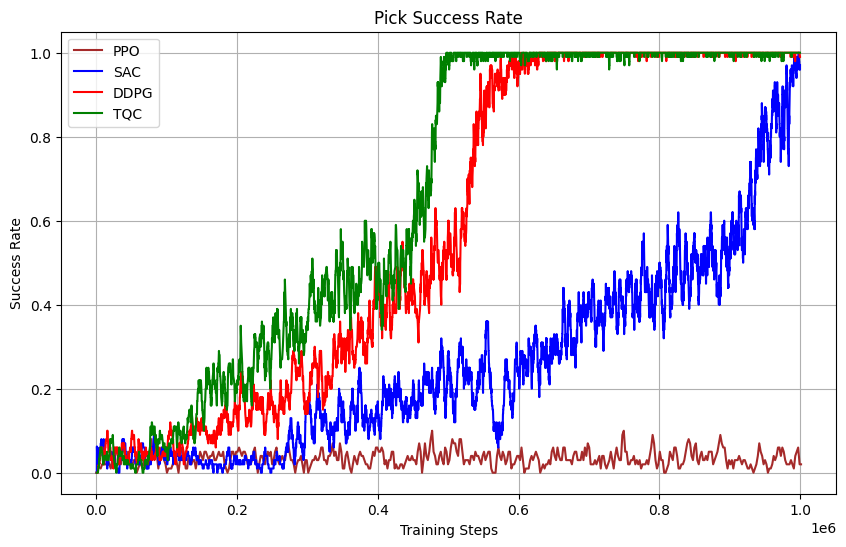

In [12]:
log_dir_1 = './tensorboard/ppo_pick/PPO_0/'
log_dir_2 = './tensorboard/sac_pick/SAC_0/'
log_dir_3 = './tensorboard/ddpg_pick/DDPG_0/'
log_dir_4 = './tensorboard/tqc_pick/TQC_0/'

df1 = load_success_rate(log_dir_1)
df2 = load_success_rate(log_dir_2)
df3 = load_success_rate(log_dir_3)
df4 = load_success_rate(log_dir_4)

plt.figure(figsize=(10, 6))

plt.plot(df1['fps'], df1['success_rate'], label='PPO', color='brown')
plt.plot(df2['fps'], df2['success_rate'], label='SAC', color='blue')
plt.plot(df3['fps'], df3['success_rate'], label='DDPG', color='red')
plt.plot(df4['fps'], df4['success_rate'], label='TQC', color='green')

plt.xlabel('Training Steps')
plt.ylabel('Success Rate')
plt.title('Pick Success Rate')
plt.grid(True)
plt.legend()
plt.show()